In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
from util import *
import re
import clip
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [13]:
example_data = np.load("./dataset/sketchrnn_angel.full.npz", encoding='latin1', allow_pickle=True)

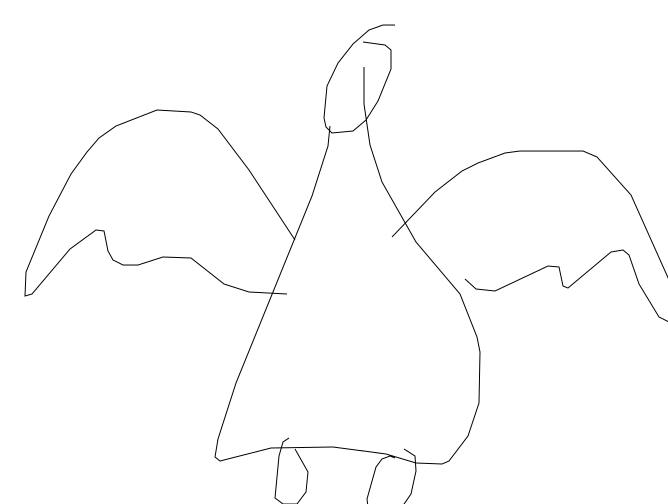

In [14]:
draw_strokes(example_data['train'][0], factor=1)

In [15]:
def encode_stroke_data(stroke_data: np.array):
    # Going from [x, y, lift_pen] to [delta_x, delta_y, pen_on_paper, pen_off_paper, finished]
    new_doodle = np.zeros((stroke_data.shape[0], 5))
    
    # Handling delta_x, delta_y
    new_row = np.zeros((1, 3))
    temp = np.vstack([new_row, stroke_data])
    new_doodle[:, :2] = temp[1:, :2] - temp[:-1, :2]
    
    # Handling pen_on_paper and pen_off_paper
    new_doodle[:, 2] = stroke_data[:, 2] == 0
    new_doodle[:, 3] = stroke_data[:, 2] == 1

    # Handling finished
    new_doodle[-1, 2] = 0 
    new_doodle[-1, 3] = 0 
    new_doodle[-1, 4] = 1

    return new_doodle

def decode_stroke_data(stroke_data: np.array):
    # Going from [delta_x, delta_y, pen_on_paper, pen_off_paper, finished] to [x, y, lift_pen]
    new_doodle = np.zeros((stroke_data.shape[0], 3))
    new_doodle[:, :2] = np.cumsum(stroke_data[:, :2], axis=0)    
    new_doodle[:, 2] = np.logical_or(stroke_data[:, 3], stroke_data[:, 4])
    return new_doodle

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
clip_model, _ = clip.load("ViT-B/32", device=device)

In [ ]:
class DoodleDataset(Dataset):
    def __init__(self, data_dir: Path, split: str, max_len):
        self.data_dir = data_dir
        self.max_len = max_len
        self.data = {}
        self.class_embeddings = {}
        
        print("Preprocessing Data:")
        for filepath in tqdm(self.data_dir.glob("*.npz")):
            class_name = self._extract_class_name(filepath)
            class_data = self._extract_data(filepath, split)
            blocks = self._break_into_blocks(class_data)            
            self.data[class_name] = blocks
        
        print("Calculating CLIP Embeddings")
        class_names = list(self.data.keys())
        tokenized_classnames = clip.tokenize(class_names)
        with torch.no_grad():
            text_features = clip_model.encode_text(tokenized_classnames.to(device))
        
        for class_name, class_features in zip(class_names, text_features):
            self.class_embeddings[class_name] = class_features

        # Fancy preprocessing for faster indexing        
        self.class_order_counts = [(class_name, len(class_data)) for class_name, class_data in self.data.items()]
        self.class_order_count_cumsum = [0]
        for _, class_count in self.class_order_counts:
            self.class_order_count_cumsum.append(self.class_order_count_cumsum[-1] + class_count)

    def __len__(self):
        return sum(len(class_data) for _, class_data in self.data.items())

    def __getitem__(self, idx):
        assert idx < self.class_order_count_cumsum[-1], f"Index of {idx} is out of bounds, dataset has size {self.__len__()}"
        
        # Binary search would be slower than linear search for the amount of classes we have.
        class_idx = -1
        while idx > self.class_order_count_cumsum[class_idx]:
            class_idx += 1
        
        class_name = self.class_order_counts[class_idx][0]
        in_class_idx = idx - self.class_order_count_cumsum[class_idx]
        return (self.data[class_name][in_class_idx], self.class_embeddings[class_name])

    def _extract_class_name(self, file: Path):
        # Example filename: `sketchrnn_apple.full.npz`
        pattern = r"sketchrnn_([^.]+)\.full\.npz"
        match = re.match(pattern, file.name)
        assert match, f"Regex for detecting classname failed on {file}"        
        return match.group(1)

    def _extract_data(self, file: Path, split: str):
        assert split in ["train", "test", "valid"], f"Split {split} is not one of: train, test, valid!"

        raw_data = np.load(file, encoding='latin1', allow_pickle=True)[split]
        encoded_doodles = []
        for doodle in raw_data:
            encoded_doodles.append(encode_stroke_data(doodle))
        
        return encoded_doodles
    
    def _break_into_blocks(self, doodle: np.array) -> np.array:
        """Break a doodle into blocks of size self.max_len with stride 1.
        
        Args:
            doodle (np.array): Array of shape (num_strokes, 5) containing stroke data
            
        Returns:
            np.array: Array of shape (num_blocks, max_len, 5) containing overlapping blocks
        """
        if len(doodle) < self.max_len:
            # Padded tokens should indicate that the doodle has completed
            padded = np.zeros((self.max_len, 5))
            padded[:len(doodle)] = doodle
            padded[len(doodle):, -1] = 1
            return np.array([padded])
        
        
        blocks = []
        for i in range(len(doodle) - self.max_len + 1):
            block = doodle[i:i + self.max_len]
            blocks.append(block)
        
        return np.array(blocks)


train_dataset = DoodleDataset(Path("./dataset"), split="train", max_len=30)
train_dataloader = DataLoader(train_dataset, batch_size=256)

# test_dataset = DoodleDataset(Path("./dataset"), split="test")
# test_dataloader = DataLoader(test_dataset, batch_size=256)

Preprocessing Data:


0it [00:00, ?it/s]

0it [00:01, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (130272, 30) + inhomogeneous part.

In [19]:
import torch.nn as nn

class StrokeEncoderMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        return self.net(x)

In [27]:
max_len = max(len(train_dataset[i][0]) for i in range(len(train_dataset)))
min_len = min(len(train_dataset[i][0]) for i in range(len(train_dataset)))

min_len, max_len

(49, 148)